# Proyecto Linea 82 SENA-Centro de Gestión Industrial-SENNOVA

**Desarrolladores:**
* **Juan Sebastian Roa Bonilla**
* **Raul Bruges Moreno**

### Importar librerías necesarias

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import os

### Establcer Constantes/Parámetros para usar a lo largo de la modelación

In [20]:
BATCH_SIZE = 100
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=35

In [3]:
# Verificación de directorio
directory=os.getcwd()
directory

'C:\\REPOSITORIES\\proyecto_linea_82\\Modelo'

### Importar Tensor Flow dataset para menejo y cargue de la imágenes de muestra

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\REPOSITORIES\proyecto_linea_82\Imagenes de entrenamiento",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3838 files belonging to 4 classes.


In [5]:
# Verificación de clases (Mazorca, Uchuva, Frijol, Arveja)

class_names = dataset.class_names
class_names

['Arveja', 'Frijol', 'Mazorca', 'Uchuvas']

### Visualización de algunas imágenes de muestra

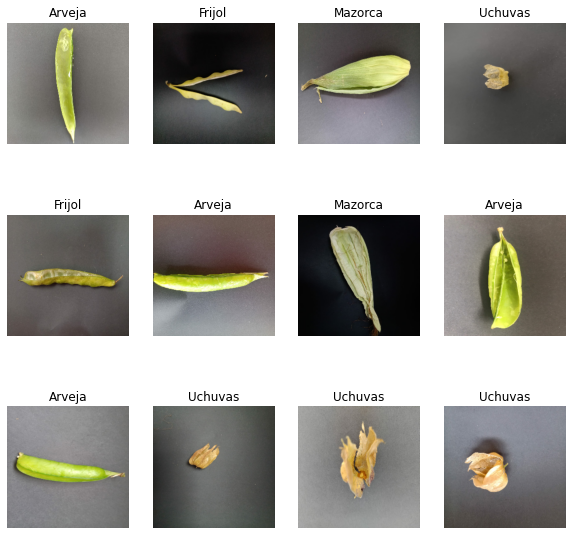

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Definición de una función para realizar la partición de las imágenes en datos de entrenamiento, validación y prueba

La información (fotos) debe ser dividida en 3 conjuntos:
1. Entrenamiento(train): Datos para ser utilizados en la fase de entrenamiento
2. Validación(val): Datos para probar el modelo durante la fase de entrenamiento
3. Prueba (test): Datos para probar despues de la fase de entrenamiento (datos desconocidos para el modelo)

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
# Verificación de la función anteriormente definida
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

print(f'Total 3 conjuntos:{len(train_ds)+len(val_ds)+len(test_ds)}')

31
3
5
Total 3 conjuntos:39


### Cache, Shuffle, and Prefetch the Dataset

Se usa para mejorar el desempeño durante la ejecución del modelo. Mejora la capacidad de memoria de máquina

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Construcción del Modelo

### Redimensionar y Normalizar las fotos


En esta fase se redimensionan las fotos y se normalizan para mejorar el desempeño del modelo. Esta fase tambien se conoce como **preprocesamiento**

In [10]:
redim_norm = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation
Data Augmentation se usa para generar muestras adicionales a las ya tomadas en campo. Esto ayuda a mejorar la precisión del modelo ya que se generan sintéticamente más muestras

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Se aplica data augmentation al conjuto de datos de entrenamiento

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



## Arquitectura del Modelo

Se usará una red neuronal convolucional con función de activación Softmax en la capa de salida. Se incluyen adicionalmente las capas de para normalización, redimensionamiento y data augmentation.

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    redim_norm,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [14]:
# Exploración del reporte del modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (100, 256, 256, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (100, 254, 254, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (100, 127, 127, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (100, 125, 125, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (100, 62, 62, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (100, 60, 60, 64)         36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (100, 30, 30, 64)        

### Compilación del modelo
Se define el optimizador para la red neuronal, función de pérdida y métrica de error, en este caso precisión.

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Entrenamiento del Modelo
Se ejecuta el entrenamiento de la red neuronal convolucional.

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/35
31/31 [==============================] - 228s 7s/step - loss: 0.0993 - accuracy: 0.9619 - val_loss: 0.0591 - val_accuracy: 0.9733
Epoch 2/35
31/31 [==============================] - 261s 8s/step - loss: 0.0912 - accuracy: 0.9674 - val_loss: 0.0638 - val_accuracy: 0.9733
Epoch 3/35
31/31 [==============================] - 284s 9s/step - loss: 0.0961 - accuracy: 0.9674 - val_loss: 0.0422 - val_accuracy: 0.9867
Epoch 4/35
31/31 [==============================] - 269s 9s/step - loss: 0.0940 - accuracy: 0.9681 - val_loss: 0.0867 - val_accuracy: 0.9700
Epoch 5/35
31/31 [==============================] - 289s 9s/step - loss: 0.1060 - accuracy: 0.9594 - val_loss: 0.1338 - val_accuracy: 0.9500
Epoch 6/35
31/31 [==============================] - 267s 9s/step - loss: 0.1530 - accuracy: 0.9429 - val_loss: 0.1371 - val_accuracy: 0.9500
Epoch 7/35
31/31 [==============================] - 313s 10s/step - loss: 0.1261 - accuracy: 0.9539 - val_loss: 0.1353 - val_accuracy: 0.9600
Epoch 8/35
3

## Medición de Precisión del modelo

In [22]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 11s 2s/step - loss: 0.0382 - accuracy: 0.9880


## Visualización de Precisión y Función de Pérdida

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

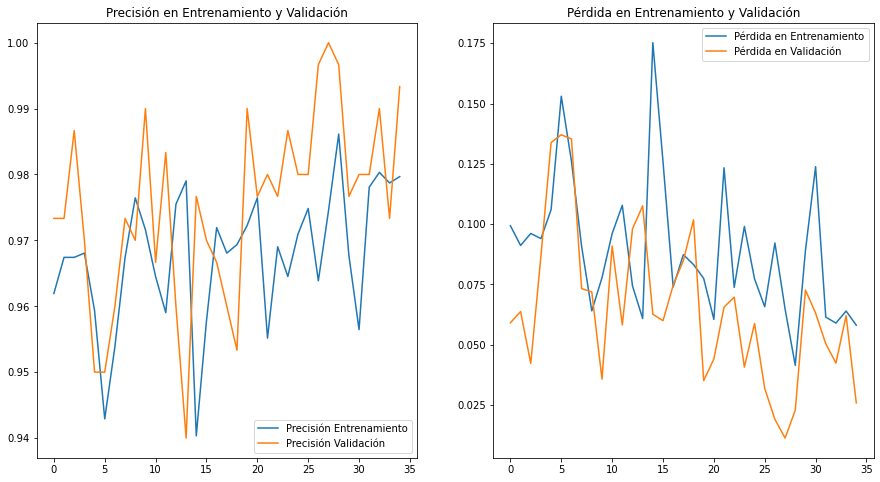

In [25]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Precisión Entrenamiento')
plt.plot(range(EPOCHS), val_acc, label='Precisión Validación')
plt.legend(loc='lower right')
plt.title('Precisión en Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Pérdida en Entrenamiento')
plt.plot(range(EPOCHS), val_loss, label='Pérdida en Validación')
plt.legend(loc='upper right')
plt.title('Pérdida en Entrenamiento y Validación')
plt.show()

### Predicción de prueba sobre una imagen

Imagen de prueba para predicción
Residuo real: Arveja
Predicción del residuo: Arveja


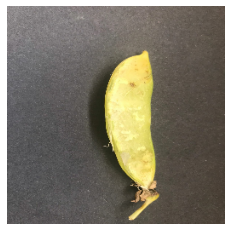

In [33]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Imagen de prueba para predicción")
    plt.imshow(first_image)
    plt.axis('off')
    print("Residuo real:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicción del residuo:",class_names[np.argmax(batch_prediction[0])])

### Definición de función para predicciones

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Predicciones sobre algunas muestras de prueba (desconocidas para el modelo hasta este punto)**

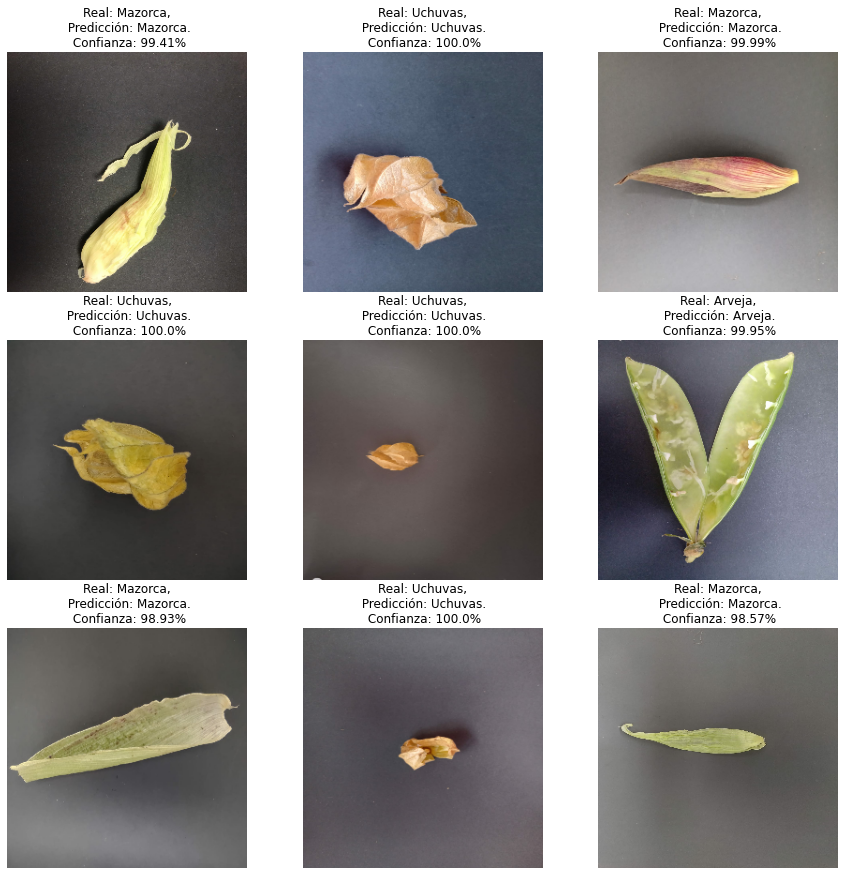

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Real: {actual_class},\n Predicción: {predicted_class}.\n Confianza: {confidence}%")
        
        plt.axis("off")

### Guardar el modelo en el espacio de trabajo


In [42]:
model_version=max([int(i) for i in os.listdir("../Modelos_Finales") + [0]])+1
model.save(f"../Modelos_Finales/{model_version}")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Modelos_Finales/1\assets


In [41]:
model.save("../modelo.h5")